In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from matplotlib import cm

In [2]:
df = pd.read_excel("../data/premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [3]:
df.shape

(50000, 13)

### Data Cleaning: Converting titles into consistent names with lower case and underscore between 2 words

In [4]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Handling NA Values

In [5]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Checking for duplicate values. If new file contains duplicates, the code can adjust for that

In [7]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Checking for and treating negative number of dependents

In [9]:
df[df.number_of_dependants<0].shape

(72, 13)

In [10]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [11]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

### Checking for outliers in other numeric columns

In [12]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

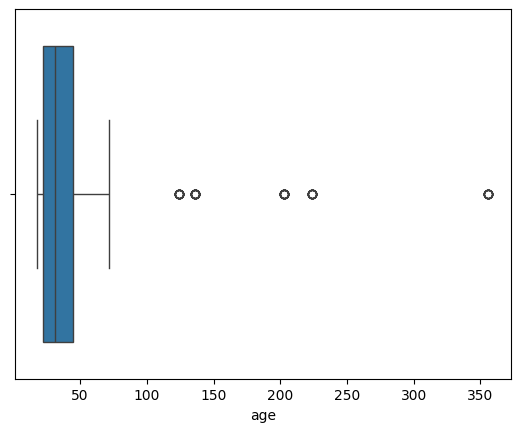

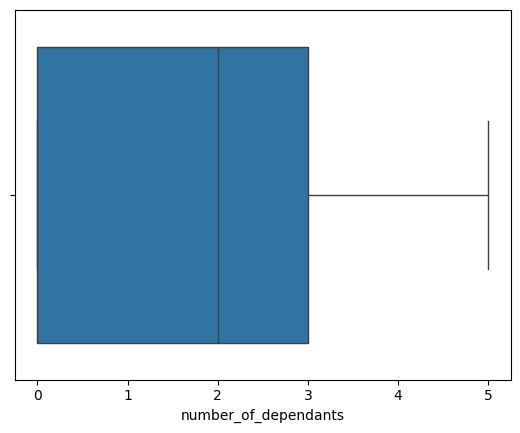

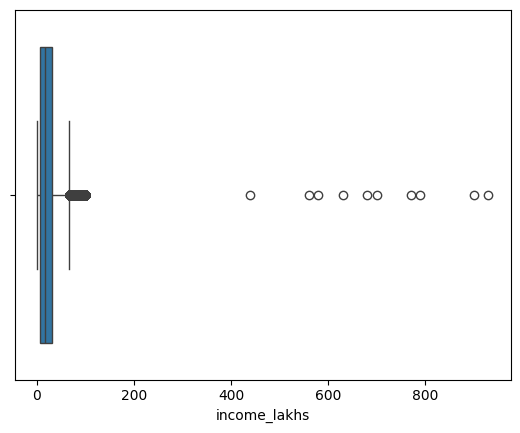

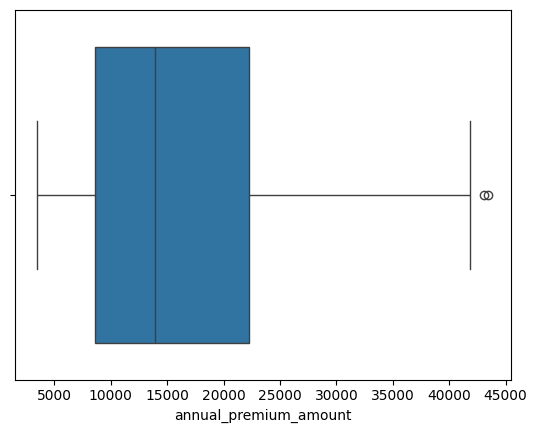

In [13]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [14]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [15]:
#Dropping all rows with age > 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

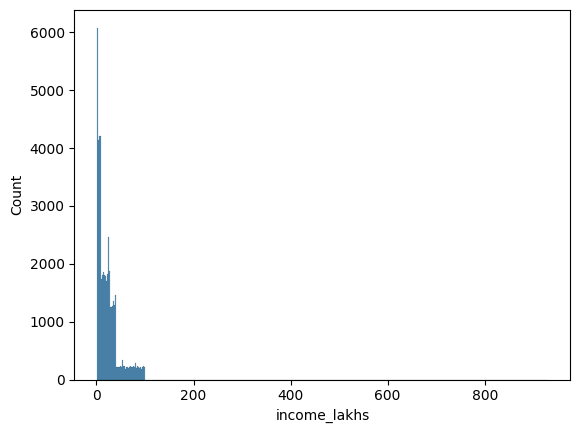

In [16]:
sns.histplot(df1.income_lakhs)

In [17]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [18]:
get_iqr_bounds(df.income_lakhs)

(-29.0, 67.0)

In [19]:
#Upper bound is 67 Lakhs per annum, which is very reasonable in India. Hence, using a better upper limit using top 99% income
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [20]:
df1[df1.income_lakhs>quantile_thresold].shape

(10, 13)

#### Only 10 people in our dataset have income greater than 100 lakhs per annum, so we can safely drop these as outliers

In [21]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


### EDA 

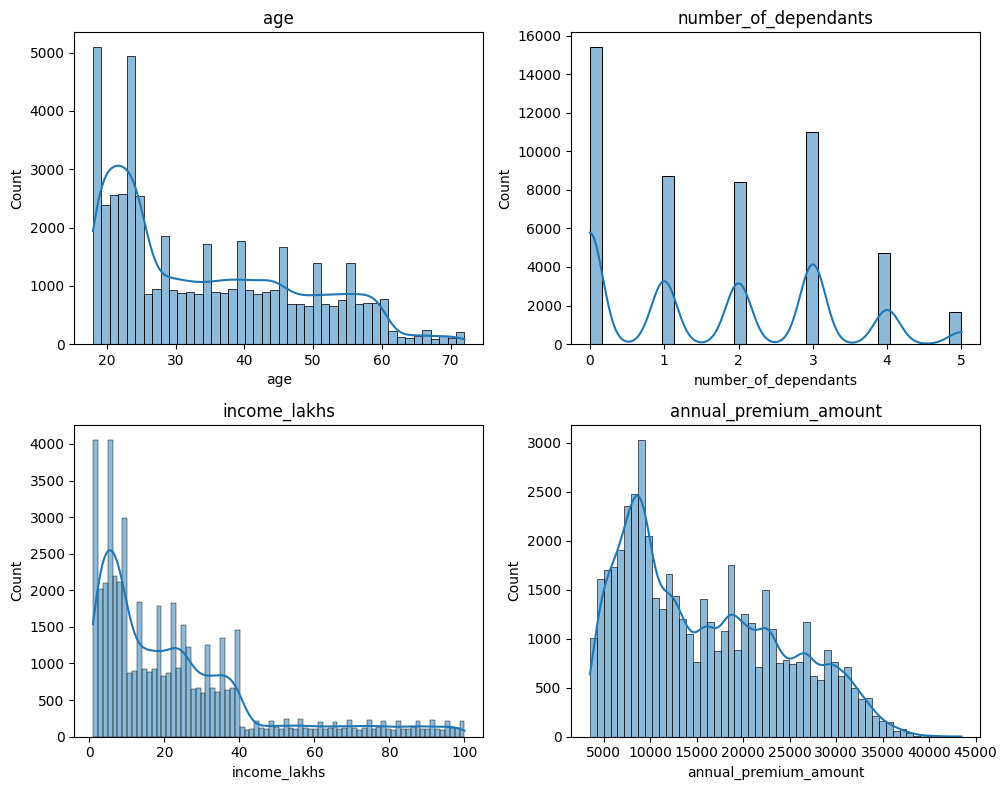

In [22]:
# Distributions for dataset after removing outliers
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs = axs.flatten()

for ax, col in zip(axs, numeric_columns):
    sns.histplot(df2[col], kde=True, ax=ax)
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

### Bi-Variate Analysis between independent numeric variables and dependent numeric variable

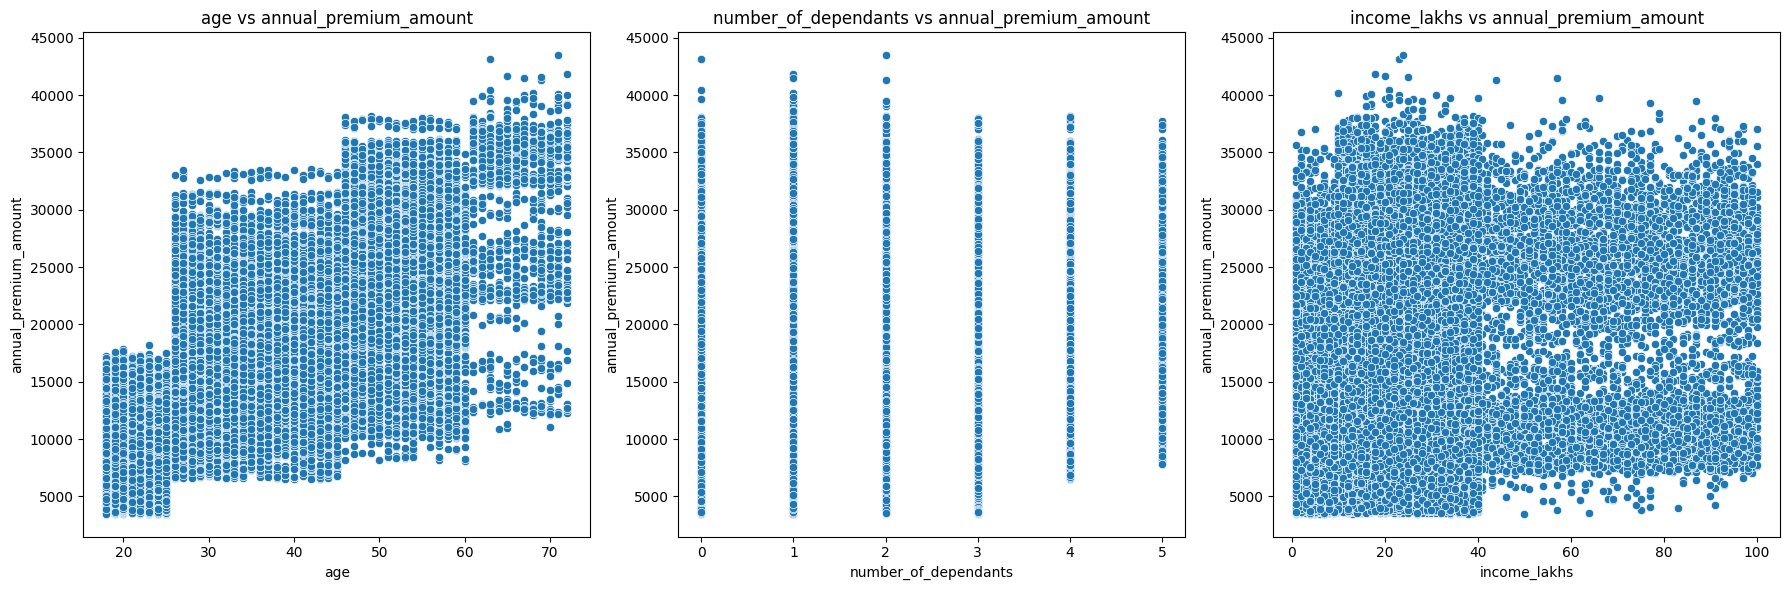

In [23]:
numeric_features = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(1, len(numeric_features), figsize = (18,6))

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f"{col} vs annual_premium_amount")
    ax.set_xlabel(col)
    ax.set_ylabel("annual_premium_amount")

plt.tight_layout()
plt.show()


### Moving on to the categorical columns

In [24]:
df2.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [25]:
categorical_cols = df2.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [26]:
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


### Replacing duplicate "No-smoking" values with one.

In [27]:
df2['smoking_status'] = df2['smoking_status'].replace({
    "Smoking=0": "No Smoking",
     "Does Not Smoke": "No Smoking",
     "Not Smoking": "No Smoking" 
})

df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [28]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

In [29]:
pct_count.values

array([0.54963132, 0.45036868])

### Percentage distribution of policy holders per categorical variable

C:\Users\kusha\AppData\Local\Temp\ipykernel_24380\2094765434.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


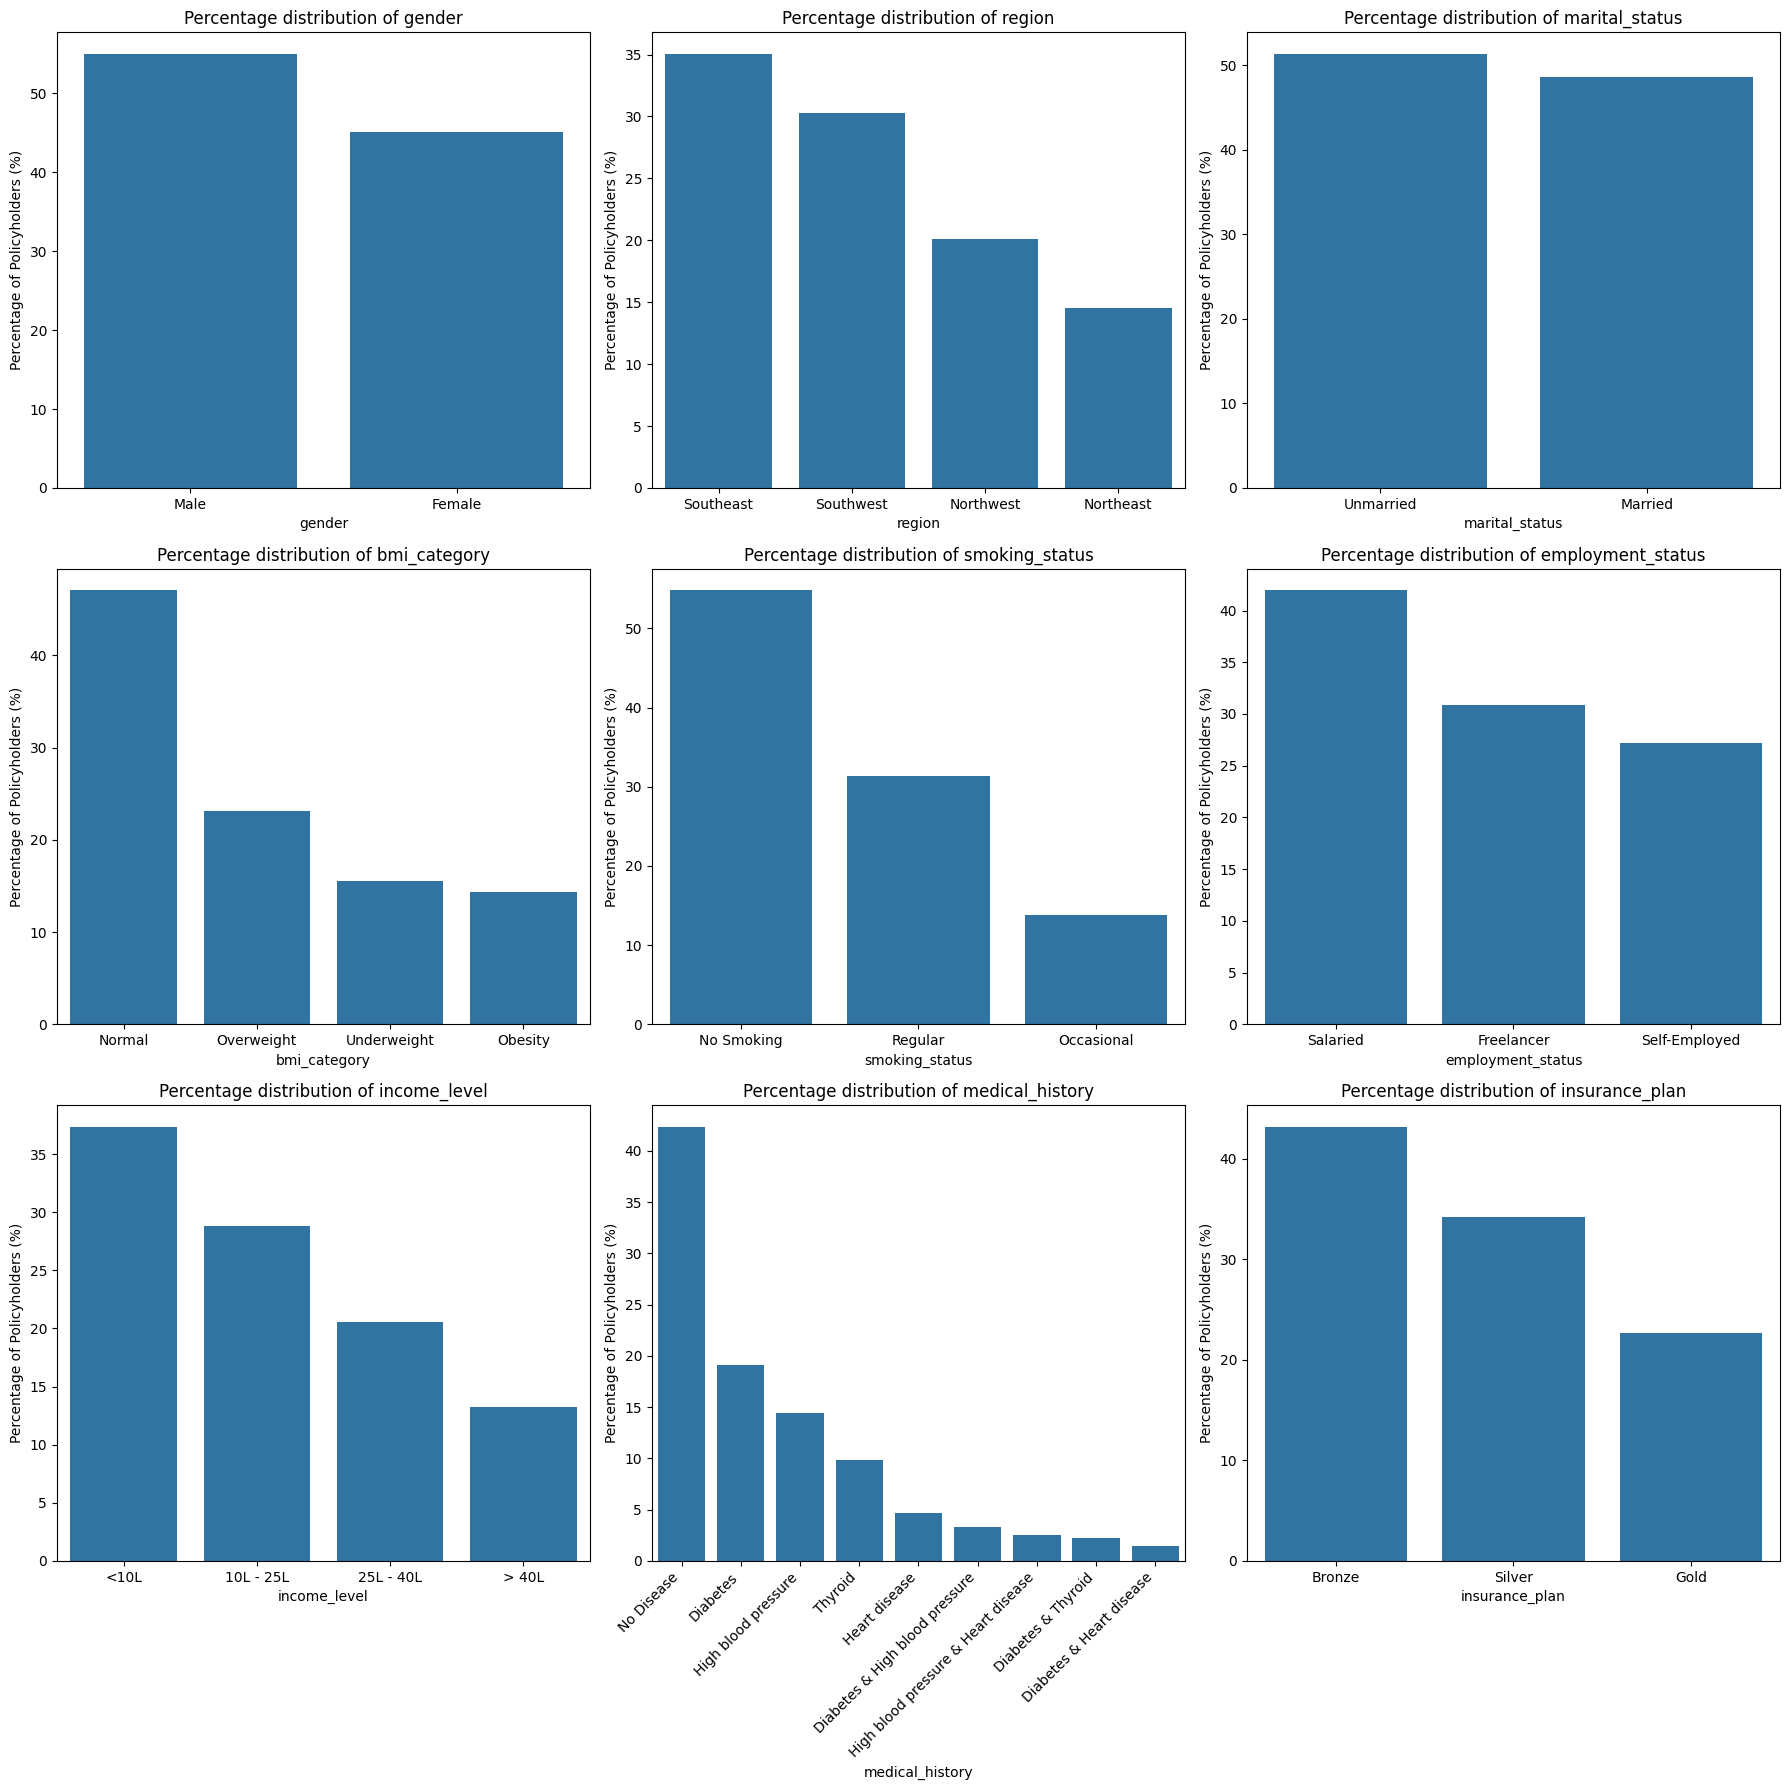

In [30]:
fig, axes = plt.subplots(3,3, figsize = (18,18))
axes = axes.flatten()

for ax,col in zip(axes,categorical_cols):
    category_counts = df2[col].value_counts(normalize=True) * 100

    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage distribution of {col}")
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.set_xlabel(col)

    if col == 'medical_history':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Bivariate analysis for categorical columns: Income Level and type of Insurance Plan

In [31]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


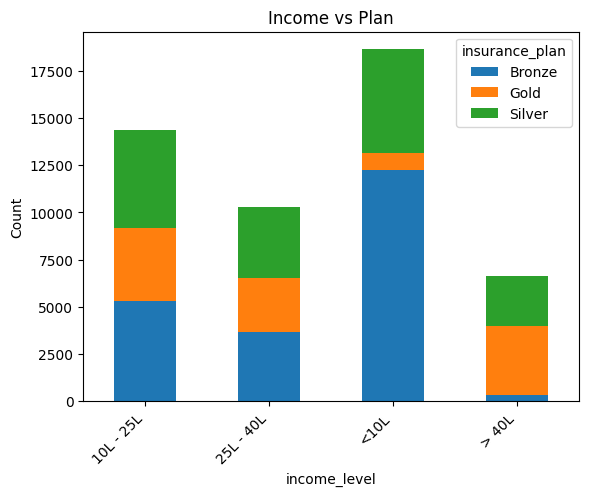

In [32]:
crosstab.plot(kind="bar", stacked = True)
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

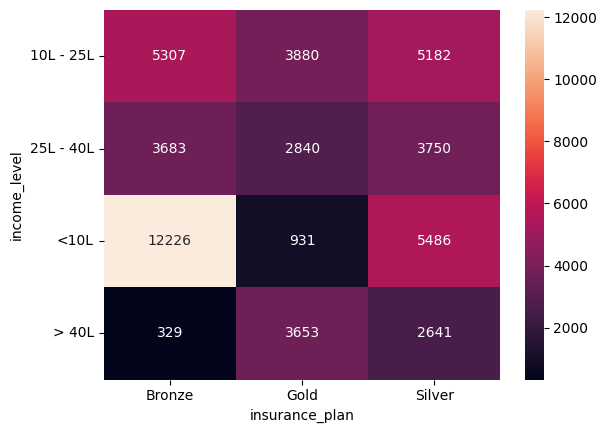

In [33]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.yticks(rotation=0)
plt.show()

### Feature Engineering

#### Ordinal variable columns

In [34]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [35]:
#Upon talking with the client, we have decided to assign certain risk scores for diseases. 
#If a person has multiple diseases, the total risk score would be the sum of individual risk scores.

risk_scores = {
    "diabetes" : 6,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "heart disease" : 8,
    "no disease": 0,
    "none": 0
}

In [36]:
#Creating new columns for multiple diseases

df2[['disease_1','disease_2']] = df2['medical_history'].str.split("&", expand=True).apply(lambda x:x.str.lower().str.strip())
df2.head(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,None
6,33,Male,Southeast,Married,3,Normal,Regular,Self-Employed,<10L,4,Diabetes & High blood pressure,Silver,20653,diabetes,high blood pressure
7,43,Male,Northeast,Married,3,Overweight,Regular,Salaried,> 40L,46,Thyroid,Gold,26926,thyroid,None
8,59,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,10L - 25L,21,No Disease,Gold,26101,no disease,None
9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None


In [37]:
df2['disease_1'] = df2['disease_1'].fillna('none')
df2['disease_2'] = df2['disease_2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease_1','disease_2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score']-min_score)/(max_score-min_score)
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
8043,20,Male,Southwest,Unmarried,1,Normal,No Smoking,Freelancer,10L - 25L,12,No Disease,Silver,9352,no disease,none,0,0.000000
13956,18,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,<10L,7,No Disease,Bronze,7560,no disease,none,0,0.000000
39142,44,Male,Northwest,Married,3,Overweight,Regular,Self-Employed,> 40L,65,Thyroid,Silver,21005,thyroid,none,5,0.357143
45015,48,Male,Southwest,Married,3,Overweight,No Smoking,Self-Employed,<10L,5,Diabetes,Silver,20315,diabetes,none,6,0.428571
21674,42,Male,Southwest,Unmarried,1,Normal,Regular,Freelancer,<10L,5,No Disease,Bronze,10431,no disease,none,0,0.000000


In [38]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [39]:
insurance_plan_order = {
    'Bronze' : 1,
    'Silver' : 2,
    'Gold' : 3
}

df2['insurance_plan'] = df2['insurance_plan'].map(insurance_plan_order)
df2['insurance_plan'].unique()

array([1, 2, 3])

In [40]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [41]:
income_level_order = {
    '<10L' : 1,
    "10L - 25L" : 2,
    "25L - 40L": 3,
    "> 40L" : 4
}

In [42]:
df2['income_level'] = df2['income_level'].map(income_level_order)
df2['income_level'].unique()

array([1, 2, 4, 3])

In [43]:
df2.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


#### Nominal variable columns

In [44]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

In [45]:
# One hot encoding
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [46]:
# Dropping unnecessary columns
df4 = df3.drop(['medical_history', 'disease_1', 'disease_2', 'total_risk_score'], axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Discovering the co-relation between variables

In [47]:
cm = df4.corr()
cm

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,0.415742,0.029851,0.025060,0.496317,0.767569,0.442773,-0.002219,0.000464,0.003305,-0.003424,-0.543104,0.152496,0.153148,-0.115888,0.066596,0.059380,-0.008093,0.314684
number_of_dependants,0.415742,1.000000,0.006564,0.006074,0.256459,0.414691,0.371498,-0.003093,0.001693,0.003620,-0.000339,-0.841717,0.115397,0.110451,-0.093881,0.071762,0.094829,0.067066,0.115930
income_level,0.029851,0.006564,1.000000,0.906830,0.440428,0.271811,0.013506,0.063108,-0.003324,-0.000259,0.009367,-0.012994,-0.002244,0.007947,0.000350,-0.001340,0.020275,-0.134032,0.139333
income_lakhs,0.025060,0.006074,0.906830,1.000000,0.410753,0.243058,0.009626,0.039126,-0.005192,-0.001250,0.009929,-0.011099,0.000314,0.007150,-0.000740,0.002306,0.010948,-0.100510,0.109759
insurance_plan,0.496317,0.256459,0.440428,0.410753,1.000000,0.834148,0.260932,0.034211,-0.002821,0.004082,-0.000977,-0.316800,0.094698,0.098639,-0.073881,0.037351,0.059587,-0.041582,0.223947
annual_premium_amount,0.767569,0.414691,0.271811,0.243058,0.834148,1.000000,0.519458,0.064470,-0.005078,0.008235,-0.003828,-0.516350,0.249847,0.187103,-0.135289,0.060610,0.198829,-0.005442,0.289438
normalized_risk_score,0.442773,0.371498,0.013506,0.009626,0.260932,0.519458,1.000000,-0.003754,-0.005627,0.002019,-0.000132,-0.433916,0.101039,0.102556,-0.087996,0.071090,0.093822,0.059511,0.135824
gender_Male,-0.002219,-0.003093,0.063108,0.039126,0.034211,0.064470,-0.003754,1.000000,-0.003287,-0.002988,0.001873,0.003944,-0.031351,0.080588,-0.043000,-0.045618,0.305180,0.005559,0.001055
region_Northwest,0.000464,0.001693,-0.003324,-0.005192,-0.002821,-0.005078,-0.005627,-0.003287,1.000000,-0.368277,-0.330654,-0.001083,-0.002262,0.001194,-0.002017,-0.000669,-0.000255,0.004574,0.000110
region_Southeast,0.003305,0.003620,-0.000259,-0.001250,0.004082,0.008235,0.002019,-0.002988,-0.368277,1.000000,-0.484271,-0.003980,0.006373,0.002511,0.000211,-0.002191,-0.000401,-0.006575,0.003287


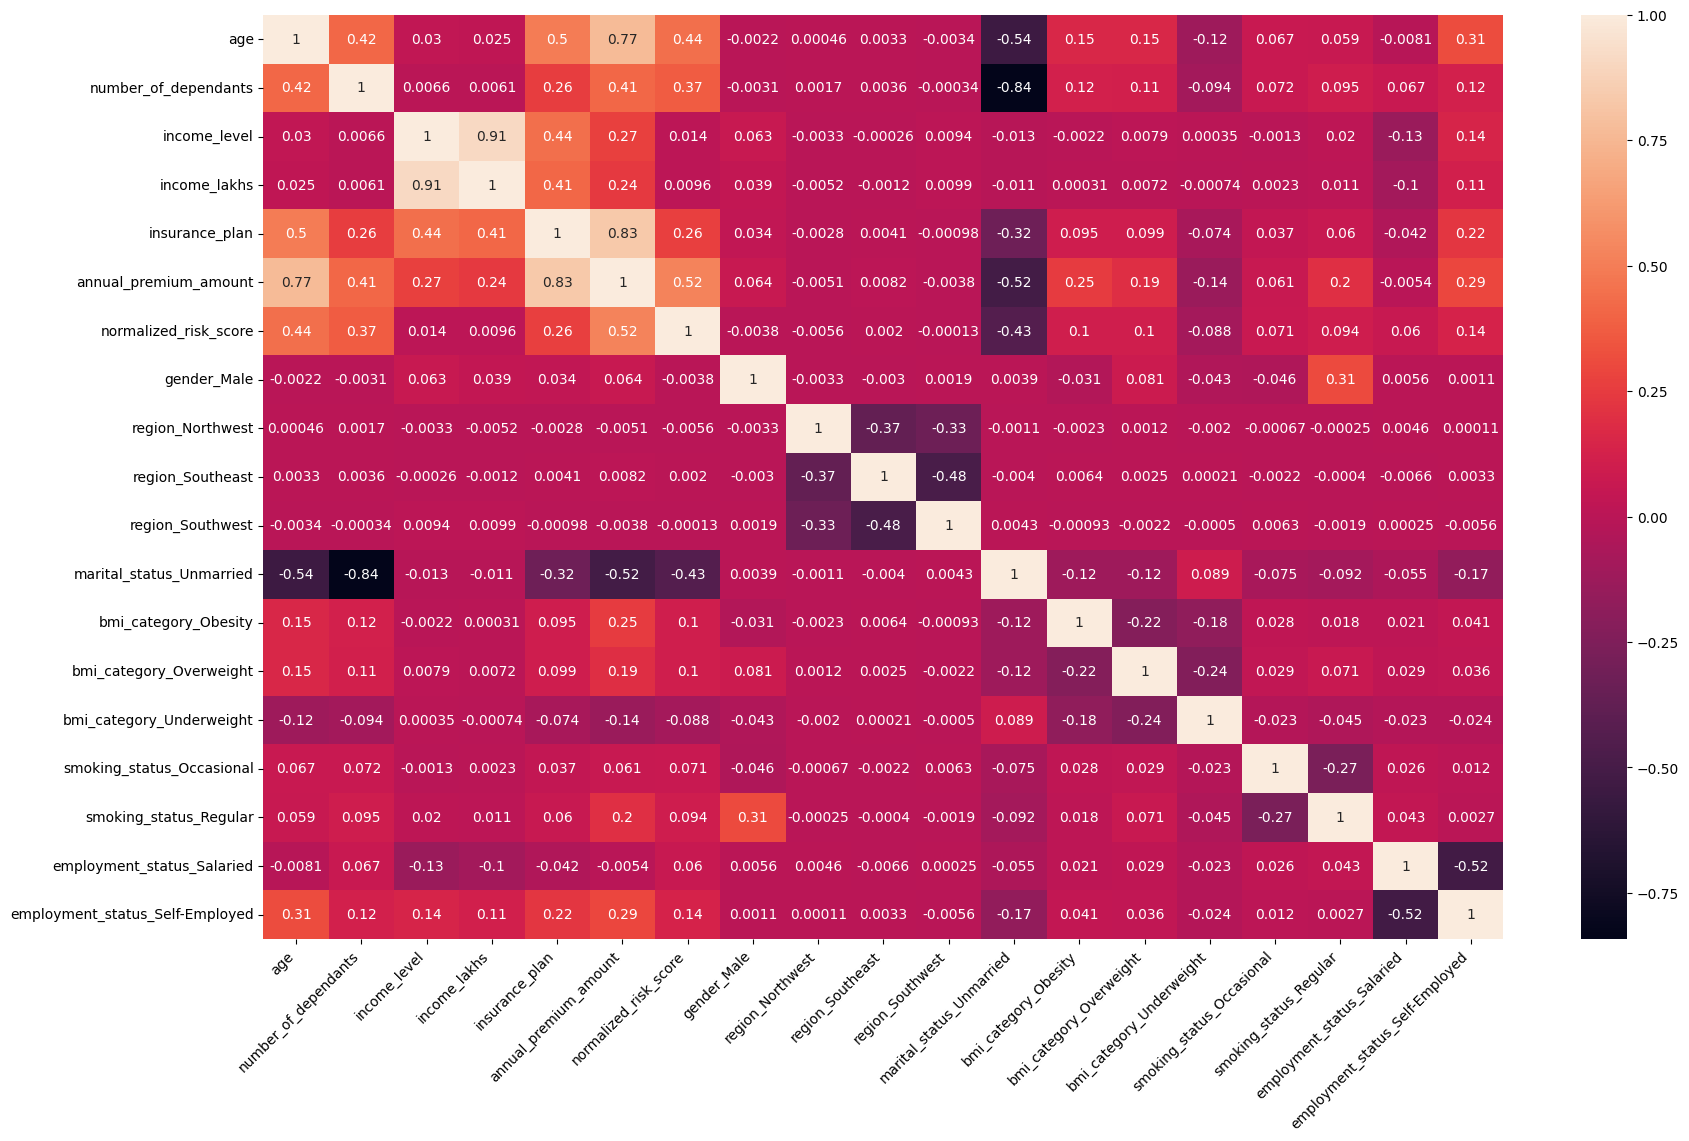

In [48]:
plt.figure(figsize = (20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout
plt.show()

### Separating independent and target variables

In [49]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

In [50]:
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Scaling all the values to be between 0 and 1

In [51]:
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [53]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Calculating VIF for independent variables

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [55]:
calculate_vif(X)

,column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [56]:
X_reduced = X.drop('income_level', axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [57]:
calculate_vif(X_reduced)

,column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


### Model Training

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print('y_test:', y_test.shape)

X_train: (34935, 17)
X_test: (14973, 17)
y_train: (34935,)
y_test: (14973,)


In [59]:
model_lr = LinearRegression()

In [60]:
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)

print(f"Train Score: {train_score}, Test Score: {test_score}")

Train Score: 0.9282143576916762, Test Score: 0.9280547230217837


In [61]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression ==> MSE:", mse_lr, "RMSE:", rmse_lr)

Linear Regression ==> MSE: 5165611.913027984 RMSE: 2272.7982561212916


### Checking how the weights of each column contribute to the final annual premium amount

In [62]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0


In [63]:
model_lr.intercept_

np.float64(4824.300272127099)

In [64]:
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [65]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


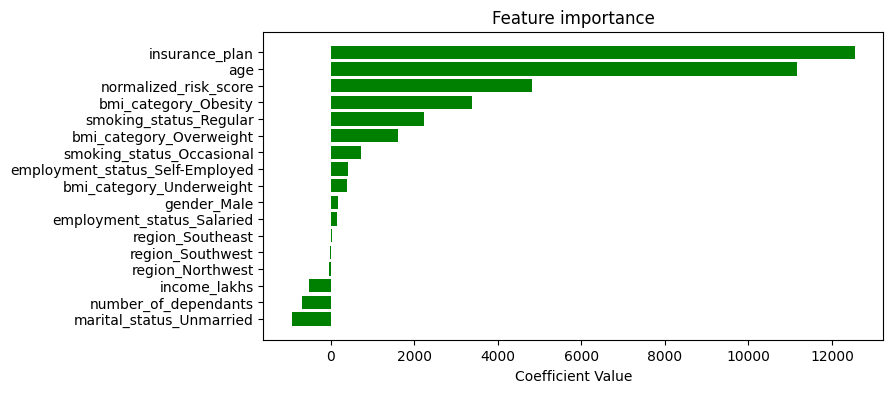

In [66]:
plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'], color= 'green')
plt.title('Feature importance')
plt.xlabel('Coefficient Value')
plt.show()

### Attempts to improve the model accuracy

In [67]:
model_rg = Ridge(alpha=10)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)

print(f"Train Score: {train_score}, Test Score: {test_score}")

Train Score: 0.9282106074563636, Test Score: 0.9280459054997704


In [68]:
from xgboost import XGBRegressor

In [69]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)

print(f"Train Score: ({train_score}), Test Score: ({test_score})")

Train Score: (0.9860964417457581), Test Score: (0.9809534549713135)


In [70]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE:", rmse_xgb)

XGBoost Regression ==> MSE: 1367525.625 RMSE: 1169.4125127601467


In [71]:
param_grid = {
    'n_estimators' : [20, 40, 50],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter = 10, cv = 3, scoring = 'r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9814704656600952)

In [72]:
random_search.best_params_

{'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}

In [73]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=40,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
best_model = random_search.best_estimator_

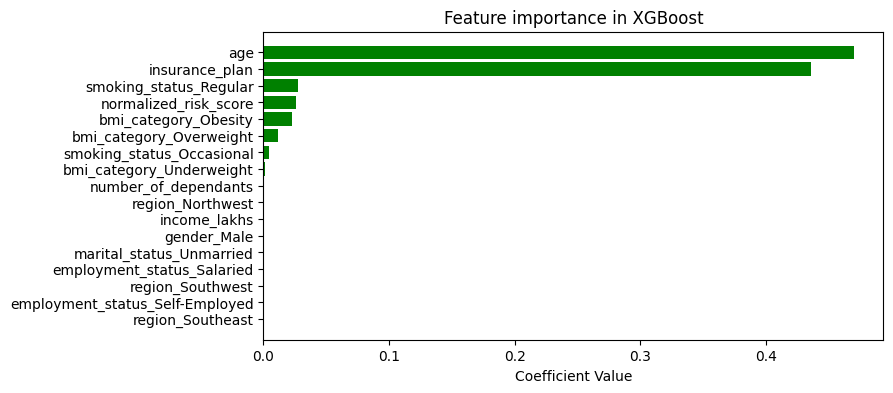

In [75]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'], color= 'green')
plt.title('Feature importance in XGBoost')
plt.xlabel('Coefficient Value')
plt.show()

### Error Analysis

In [76]:
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct':residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20481.802734,-72.197266,-0.351257
35794,29647,29399.103516,-247.896484,-0.836160
43608,20560,20621.814453,61.814453,0.300654
42730,5018,7402.557129,2384.557129,47.520070
18936,8929,8295.146484,-633.853516,-7.098819


<Axes: xlabel='diff_pct', ylabel='Count'>

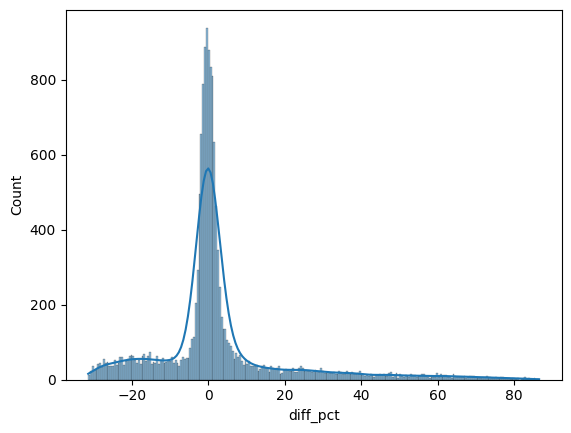

In [77]:
sns.histplot(results_df['diff_pct'], kde=True)

In [78]:
# A lot of records have more than 10% of the difference between predicted values and the actual values. 
# Solving for them, keeping threshold +/-(10%).

In [79]:
extreme_error_thresold = 10
extreme_results_df = results_df[np.abs((results_df.diff_pct))>extreme_error_thresold]
extreme_results_df.shape

(4445, 4)

In [80]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.686769518466573

In [81]:
# approx 30% predictions have absolute error of more than 10%

In [82]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending = False)

,actual,predicted,diff,diff_pct
36269,3501,6529.937012,3028.937012,86.516339
42342,3521,6529.937012,3008.937012,85.456888
18564,3523,6529.937012,3006.937012,85.351604
48801,3516,6512.600098,2996.600098,85.227534
7988,3527,6512.600098,2985.600098,84.649847
...,...,...,...,...
10335,4536,6812.687012,2276.687012,50.191513
31538,4601,6909.758789,2308.758789,50.179500
7174,4349,6529.937012,2180.937012,50.148011
12107,4647,6976.392090,2329.392090,50.126793


### 522 records show higher than 50% error margin. For the highest error margin, the actual premium was 3501, but the model predicted 6529.9. Hence, the model is not yet ready to be deployed.

In [83]:
# Next step is to figure out the root cause of these error margins

In [84]:
#The index in extreme_results_df is same as the index in X_test. So figuring out the features of these high error predictions

extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


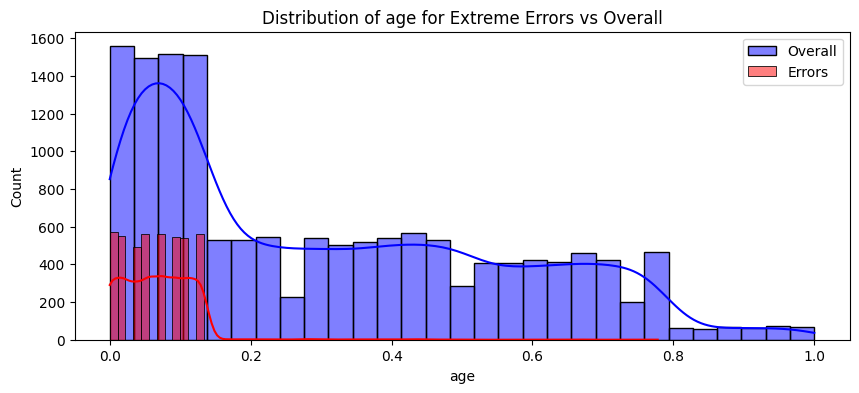

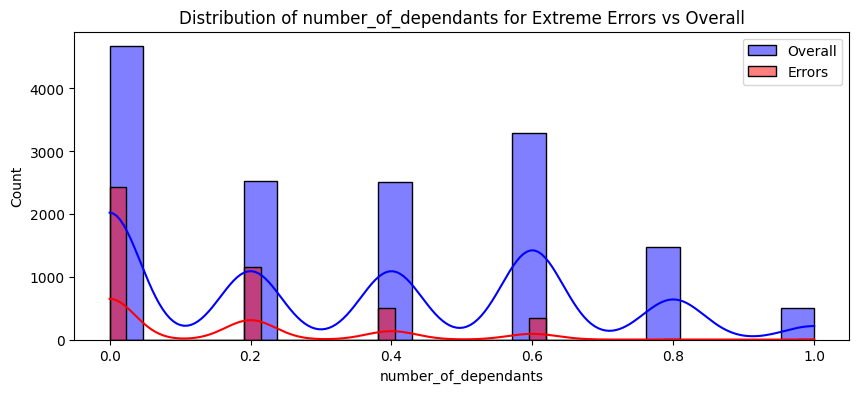

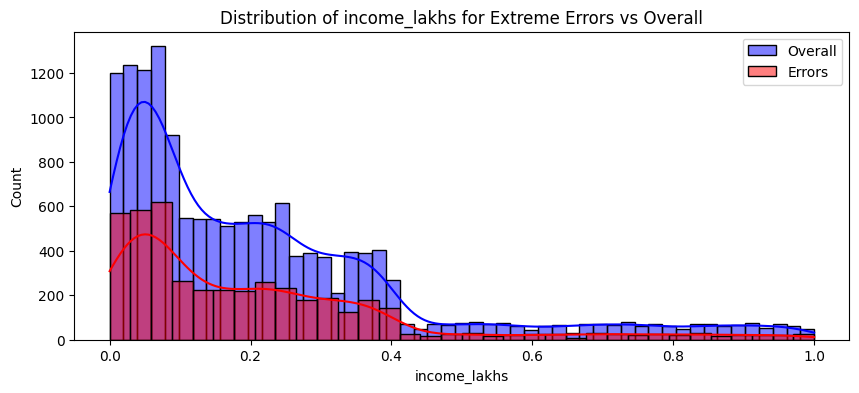

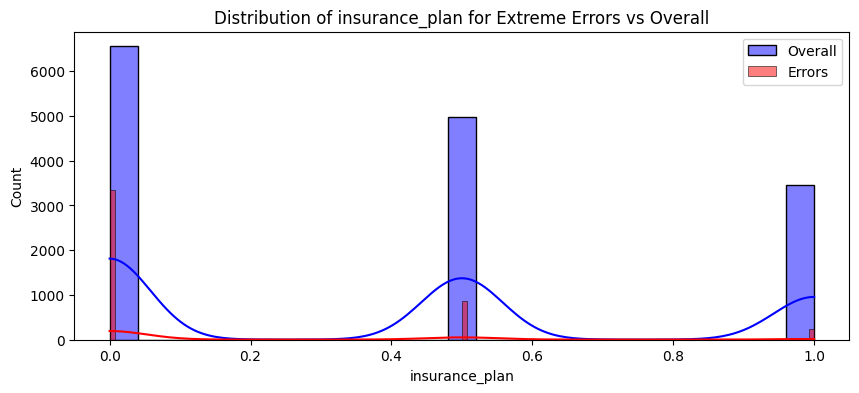

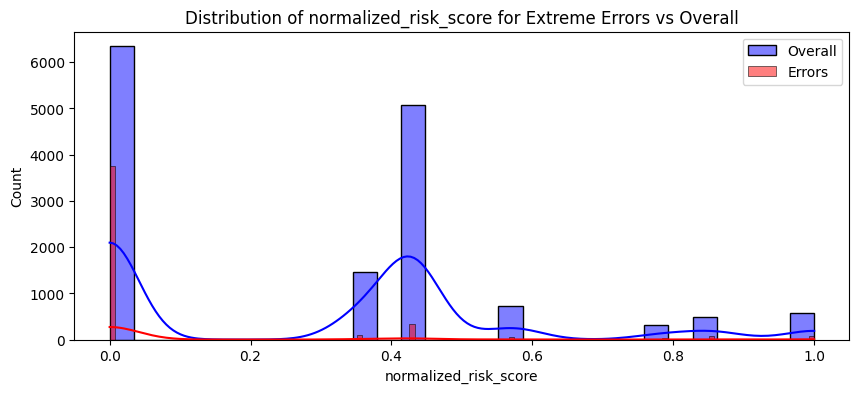

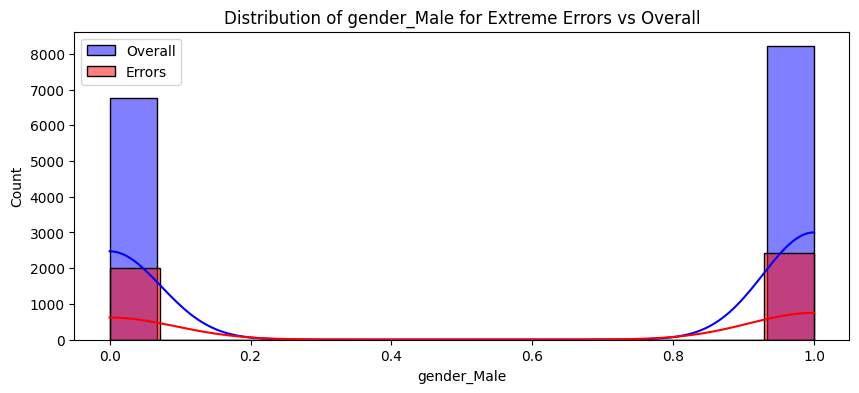

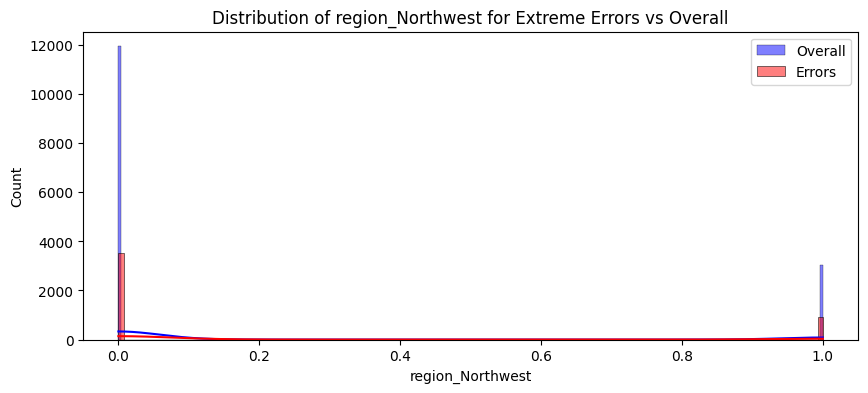

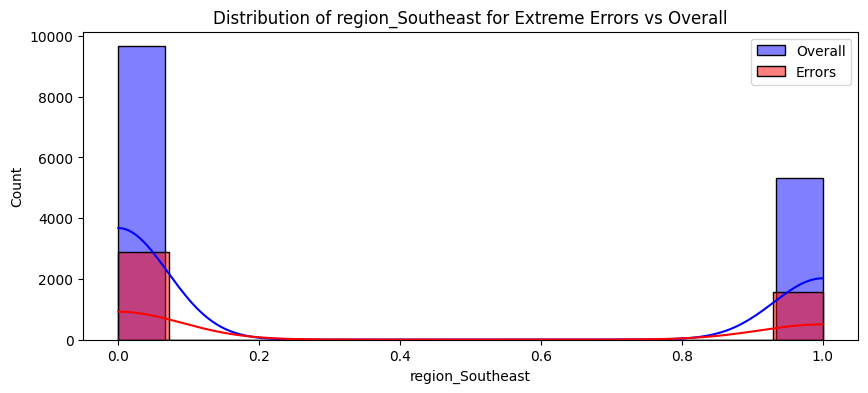

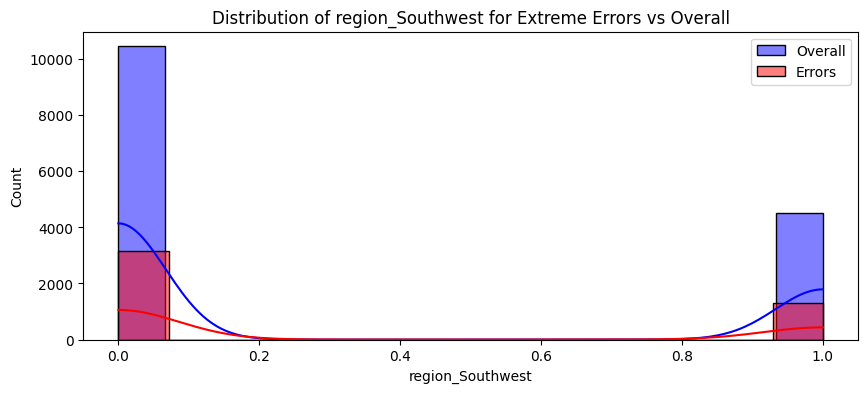

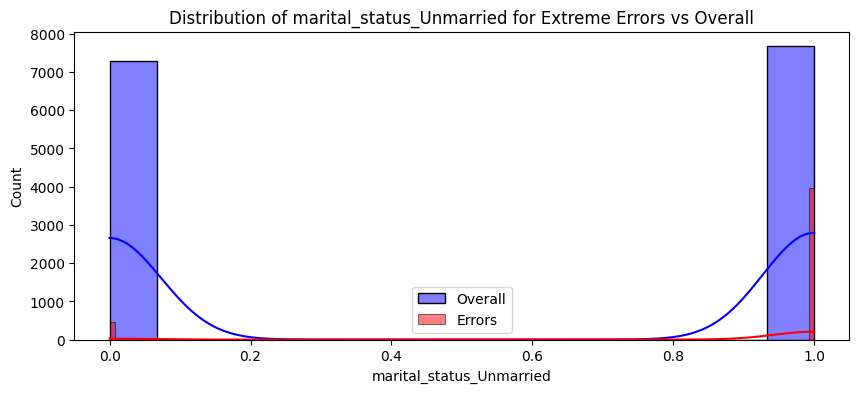

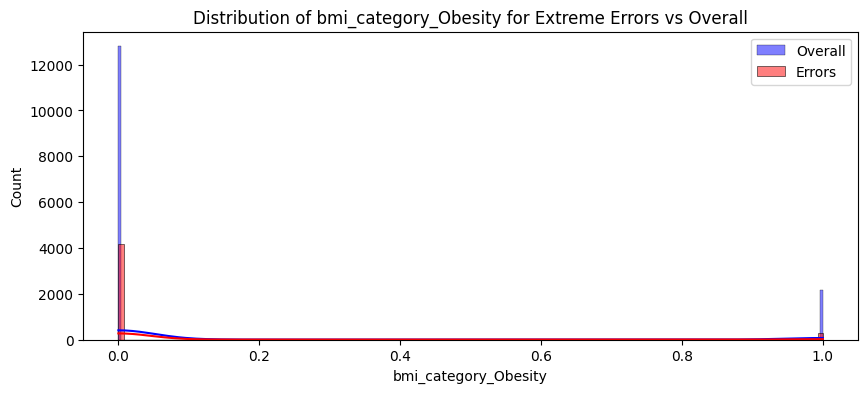

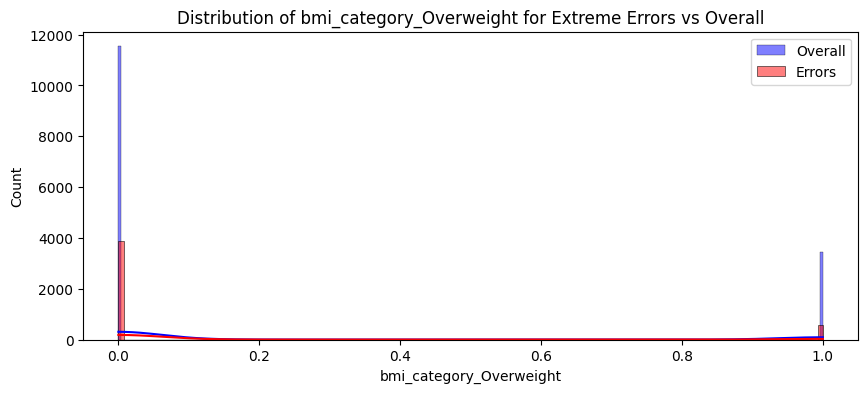

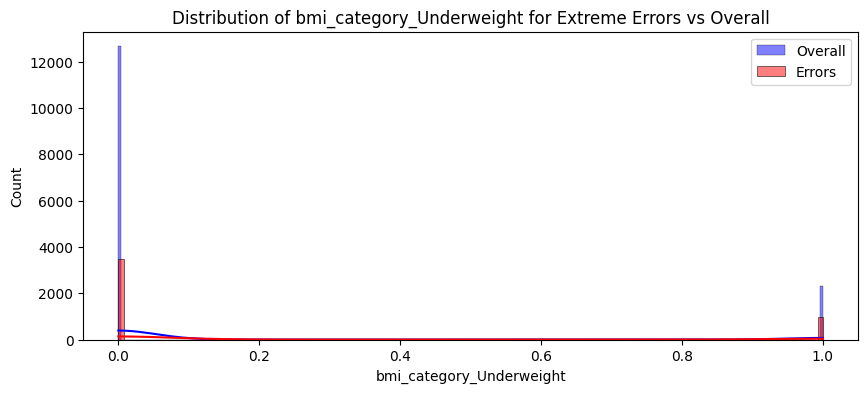

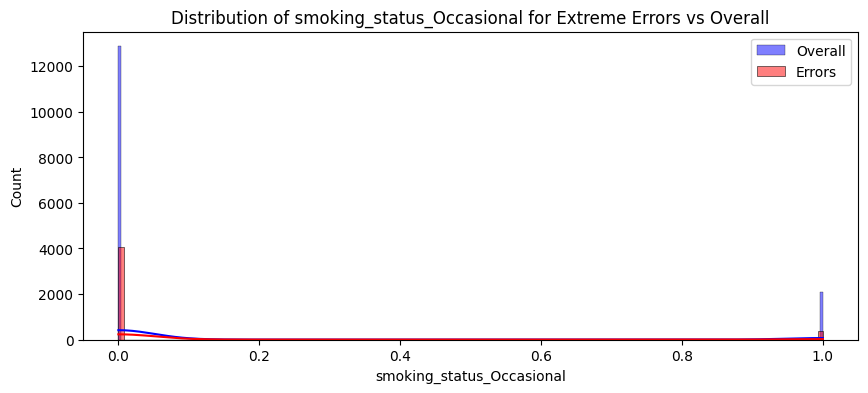

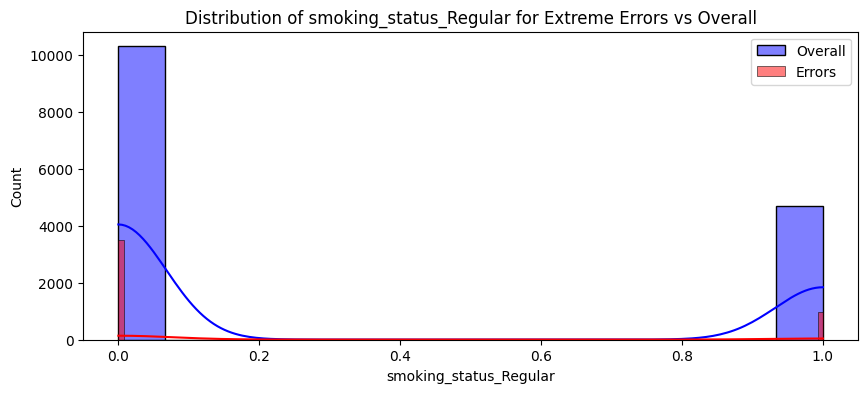

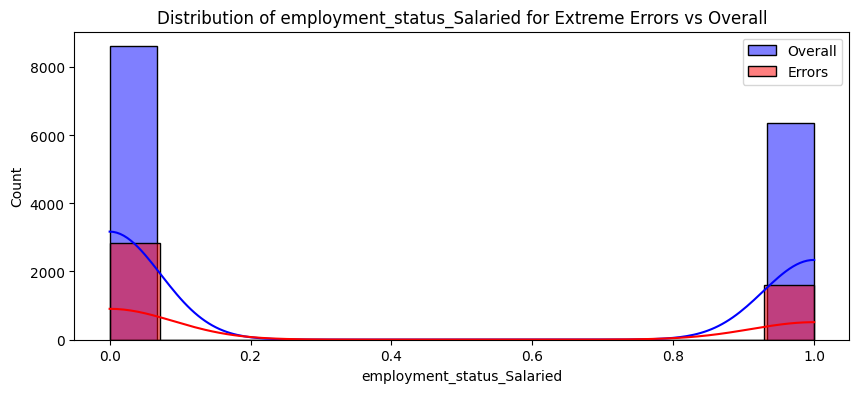

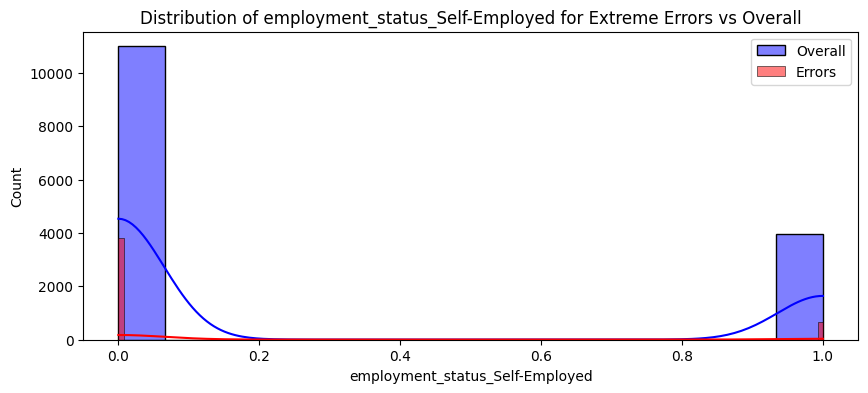

In [85]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    sns.histplot(extreme_errors_df[feature], color='red', label='Errors', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [86]:
#looking at the histograms, we can say age has some problems in predicting the values. 

<Axes: xlabel='age', ylabel='Count'>

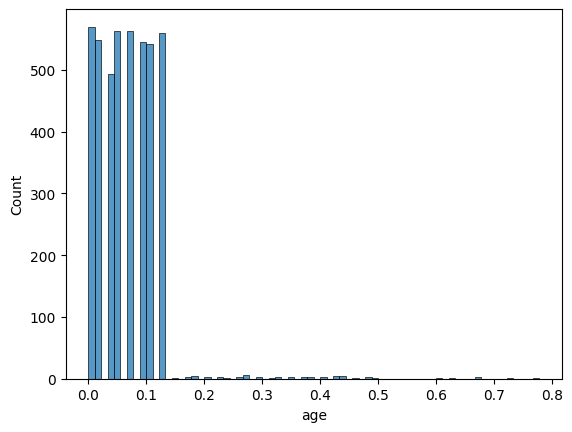

In [87]:
sns.histplot(extreme_errors_df.age)

### Reversing the scaling done previously

In [88]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [89]:
extreme_errors_df['income_level'] = -1

In [91]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed[cols_to_scale].head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


<Axes: xlabel='age', ylabel='Count'>

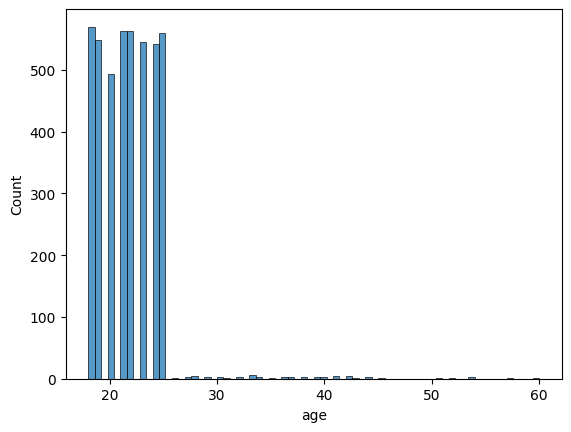

In [92]:
sns.histplot(df_reversed['age'])

In [93]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4445.000000,4445.000000,4445.0,4445.000000,4445.000000
mean,21.710011,0.724409,-2.0,21.170079,1.298313
std,3.034574,0.954571,0.0,20.604170,0.559356
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,19.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000


In [97]:
df_reversed['age'].quantile(0.98)

np.float64(25.0)

### This means 98 percent of the records in the extreme errors data are of age 25 or less.

### Further analysis is done in Notebooks named: "healthcare_premium_young", "healthcare_premium_rest", "healthcare_premium_young_with_gr", ""healthcare_premium_rest_with_gr"